load required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## Data Exploration:

The original training dataset consists of 17 elements and a total of 2276 observations. Among these elements, `INDEX` is merely an index value utilized for sorting, while `TARGET_WINS` serves as the response variable for our regression models. The remaining 15 elements represent potential predictor variables for our linear models. Below is a summary table for the dataset.


|variables       | n     | mean | sd   | med  | min  | max   | range |  skew | kurtosis | se    | NAs
|--------------  | ----- | ---- | ---- | ---- | ---- | ----- | ----- | ----- | -------  | ----- | ---
|TARGET_WINS     | 2276  |   81 |   16 |   82 |    0 |   146 |   146 | -0.40 |   1.03   |  0.33 |    
|TEAM_BATTING_H  | 2276  | 1470 |  145 | 1454 |  891 |  2554 |  1663 |  1.57 |   7.28   |  3.03 |    
|TEAM_BATTING_2B | 2276  |  241 |   47 |  238 |   69 |   458 |   389 |  0.22 |   0.01   |  0.98 |     
|TEAM_BATTING_3B | 2276  |   55 |   28 |   47 |    0 |   223 |   223 |  1.11 |   1.50   |  0.59 |    
|TEAM_BATTING_HR | 2276  |  100 |   61 |  102 |    0 |   264 |   264 |  0.19 |  -0.96   |  1.27 |    
|TEAM_BATTING_BB | 2276  |  502 |  123 |  512 |    0 |   878 |   878 | -1.03 |   2.18   |  2.57 |     
|TEAM_BATTING_SO | 2174  |  736 |  240 |  750 |    0 |  1399 |  1399 | -0.30 |  -0.32   |  5.33 |  102
|TEAM_BASERUN_SB | 2145  |  125 |   88 |  101 |    0 |   697 |   697 |  1.97 |   5.49   |  1.90 |  131  
|TEAM_BASERUN_CS | 1504  |   53 |   23 |   49 |    0 |   201 |   201 |  1.98 |   7.62   |  0.59 |  772
|TEAM_BATTING_HBP|  191  |   59 |   13 |   58 |   29 |    95 |    66 |  0.32 |  -0.11   |  0.94 | 2085
|TEAM_PITCHING_H | 2276  | 1779 | 1407 | 1518 | 1137 | 30132 | 28995 | 10.33 | 141.84   | 29.49 |     
|TEAM_PITCHING_HR| 2276  |  106 |   61 |  107 |    0 |   343 |   343 |  0.29 |  -0.60   |  1.28 |      
|TEAM_PITCHING_BB| 2276  |  553 |  166 |  536 |    0 |  3645 |  3645 |  6.74 |  96.97   |  3.49 |      
|TEAM_PITCHING_SO| 2174  |  818 |  553 |  813 |    0 | 19278 | 19278 | 22.17 | 671.19   | 11.86 |  102
|TEAM_FIELDING_E | 2276  |  246 |  228 |  159 |   65 |  1898 |  1833 |  2.99 |  10.97   |  4.77 |      
|TEAM_FIELDING_DP| 1990  |  146 |   26 |  149 |   52 |   228 |   176 | -0.39 |   0.18   |  0.59 |  286


The variables and their definitions can be seen below:

Variable|Definition
---|---
`INDEX`|Identification variable
`TARGET_WINS`|Number of wins
`TEAM_BATTING_H`|Base hits by batters (1B, 2B, 3B, HR)
`TEAM_BATTING_2B`|Doubles by batters (2B)
`TEAM_BATTING_3B`|Triples by batters (3B)
`TEAM_BATTING_HR`|Homeruns by batters (4B)
`TEAM_BATTING_BB`|Walks by batters
`TEAM_BATTING_HBP`|Batters hit by pitch (get a free base)
`TEAM_BATTING_SO`|Strikeouts by batters
`TEAM_BASERUN_SB`|Stolen bases
`TEAM_BASRUN_CS`|Caught stealing
`TEAM_FIELDING_E`|Errors
`TEAM_FIELDING_DP`|Double plays
`TEAM_PITCHING_BB`|Walks allowed
`TEAM_PITCHING_H`|Hits allowed
`TEAM_PITCHING_HR`|Homeruns allowed
`TEAM_PITCHING_SO`|Strikeouts by pitchers



In [ ]:
# Read the dataset
url = "https://raw.githubusercontent.com/waheeb123/Data-621/main/Homeworks/Homework-1/moneyball-training-data.csv"
df = pd.read_csv(url)

# Dropping INDEX column as it serves as an index
df.drop(columns=['INDEX'], inplace=True)

# Splitting the data into train and test sets
np.random.seed(30)
train = df.sample(frac=0.7)
test = df.drop(train.index)


Next, let's print out some summary statistics. We're primarily interested in the `TARGET_WINS` variable, so we'll look at that first.


The mean number of wins in a season is 80.70.
The median number of wins in a season is 82.00.
The standard deviation for number of wins in a season is 15.65.


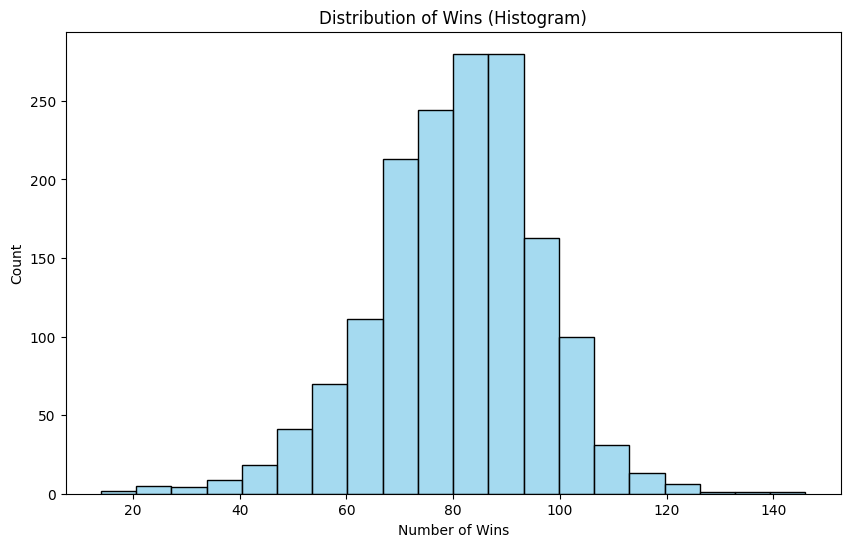

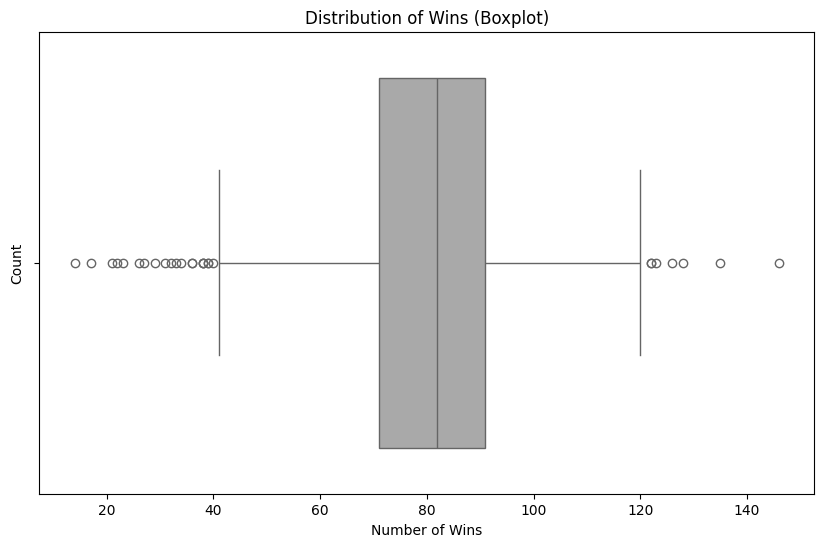

                    mean     std  median
TARGET_WINS         80.8    15.8    82.0
TEAM_BATTING_H    1469.3   144.6  1454.0
TEAM_BATTING_2B    241.2    46.8   238.0
TEAM_BATTING_3B     55.2    27.9    47.0
TEAM_BATTING_HR     99.6    60.5   102.0
TEAM_BATTING_BB    501.6   122.7   512.0
TEAM_BATTING_SO    735.6   248.5   750.0
TEAM_BASERUN_SB    124.8    87.8   101.0
TEAM_BASERUN_CS     52.8    23.0    49.0
TEAM_BATTING_HBP    59.4    13.0    58.0
TEAM_PITCHING_H   1779.2  1406.8  1518.0
TEAM_PITCHING_HR   105.7    61.3   107.0
TEAM_PITCHING_BB   553.0   166.4   536.5
TEAM_PITCHING_SO   817.7   553.1   813.5
TEAM_FIELDING_E    246.5   227.8   159.0
TEAM_FIELDING_DP   146.4    26.2   149.0


In [ ]:


# Summary statistics for TARGET_WINS variable
mean_wins = train['TARGET_WINS'].mean()
median_wins = train['TARGET_WINS'].median()
sd_wins = train['TARGET_WINS'].std()

print(f"The mean number of wins in a season is {mean_wins:.2f}.")
print(f"The median number of wins in a season is {median_wins:.2f}.")
print(f"The standard deviation for number of wins in a season is {sd_wins:.2f}.")

# Histogram of TARGET_WINS variable
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='TARGET_WINS', color='skyblue', bins=20)
plt.title("Distribution of Wins (Histogram)")
plt.xlabel("Number of Wins")
plt.ylabel("Count")
plt.show()

# Boxplot of TARGET_WINS variable
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='TARGET_WINS', color='darkgrey')
plt.title("Distribution of Wins (Boxplot)")
plt.xlabel("Number of Wins")
plt.ylabel("Count")
plt.show()

# Summary statistics for all variables
summary_stats = df.describe().loc[['mean', 'std', '50%']].round(1).transpose()
summary_stats.columns = ['mean', 'std', 'median']
print(summary_stats)


## Data Preparation:

Let's take a closer look at all the summary statistics for these variables and identify any data completeness issues:
We can see quite a few NA values for `TEAM_BATTING_SO`, `TEAM_BASERUN_SB`, `TEAM_BASERUN_CS`, `TEAM_BATTING_HBP`, `TEAM_PITCHING_SO`, and `TEAM_FIELDING_DP`. Let's take a look at the distributions of these variables to see how to impute these missing values.

       TARGET_WINS  TEAM_BATTING_H  TEAM_BATTING_2B  TEAM_BATTING_3B  \
count  2276.000000     2276.000000      2276.000000      2276.000000   
mean     80.790861     1469.269772       241.246924        55.250000   
std      15.752152      144.591195        46.801415        27.938557   
min       0.000000      891.000000        69.000000         0.000000   
25%      71.000000     1383.000000       208.000000        34.000000   
50%      82.000000     1454.000000       238.000000        47.000000   
75%      92.000000     1537.250000       273.000000        72.000000   
max     146.000000     2554.000000       458.000000       223.000000   

       TEAM_BATTING_HR  TEAM_BATTING_BB  TEAM_BATTING_SO  TEAM_BASERUN_SB  \
count      2276.000000      2276.000000      2174.000000      2145.000000   
mean         99.612039       501.558875       735.605336       124.761772   
std          60.546872       122.670862       248.526418        87.791166   
min           0.000000         0.000000    

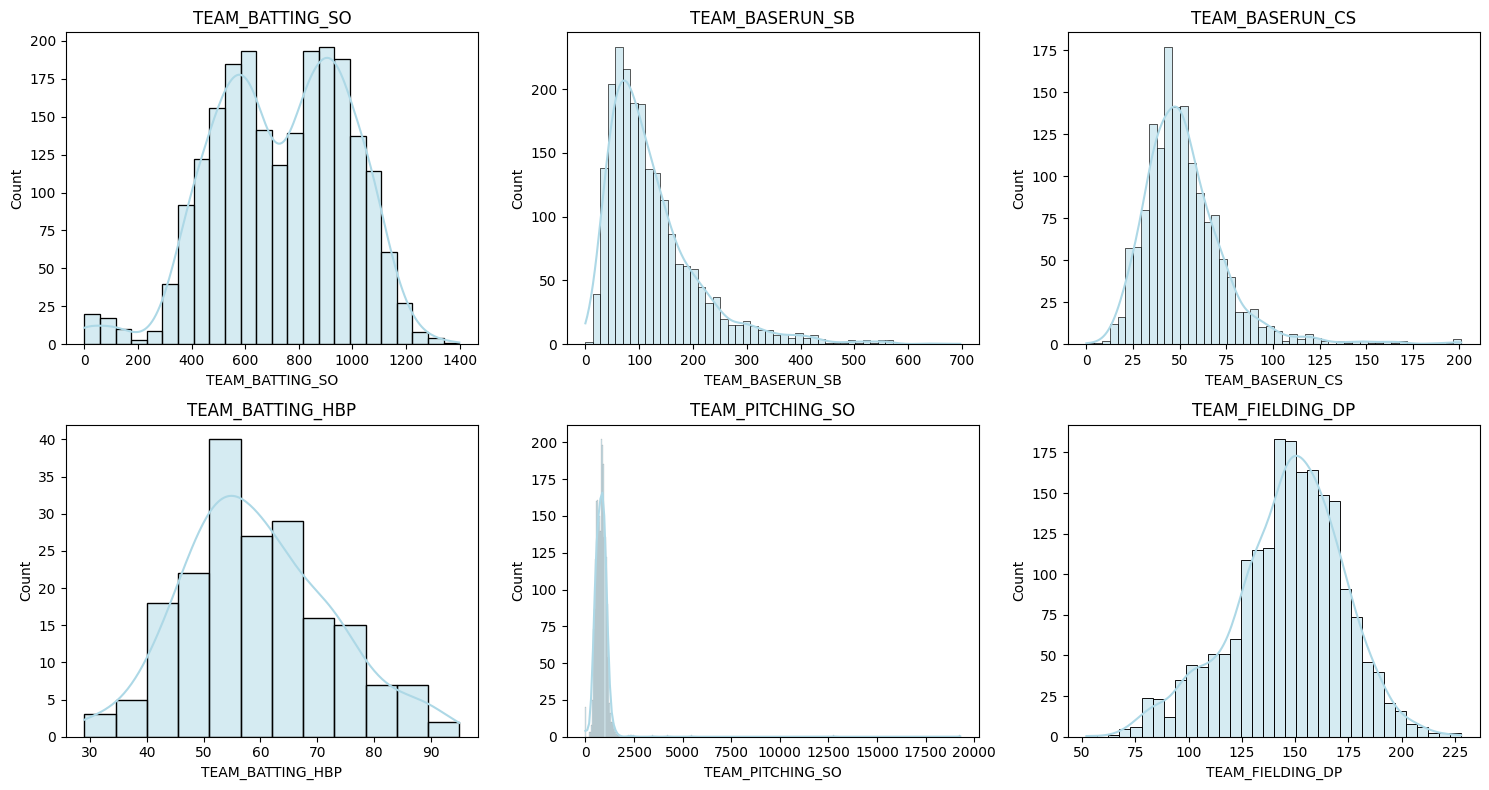

TARGET_WINS         1.000000
TEAM_BATTING_H      0.388768
TEAM_BATTING_2B     0.289104
TEAM_BATTING_BB     0.232560
TEAM_PITCHING_HR    0.189014
TEAM_BATTING_HR     0.176153
TEAM_BATTING_3B     0.142608
TEAM_PITCHING_BB    0.124175
TEAM_BASERUN_SB     0.120638
TEAM_FIELDING_DP    0.009751
TEAM_BASERUN_CS    -0.015174
TEAM_BATTING_SO    -0.034845
TEAM_PITCHING_SO   -0.077762
TEAM_PITCHING_H    -0.109937
TEAM_FIELDING_E    -0.176485
Name: TARGET_WINS, dtype: float64


<Figure size 1200x800 with 0 Axes>

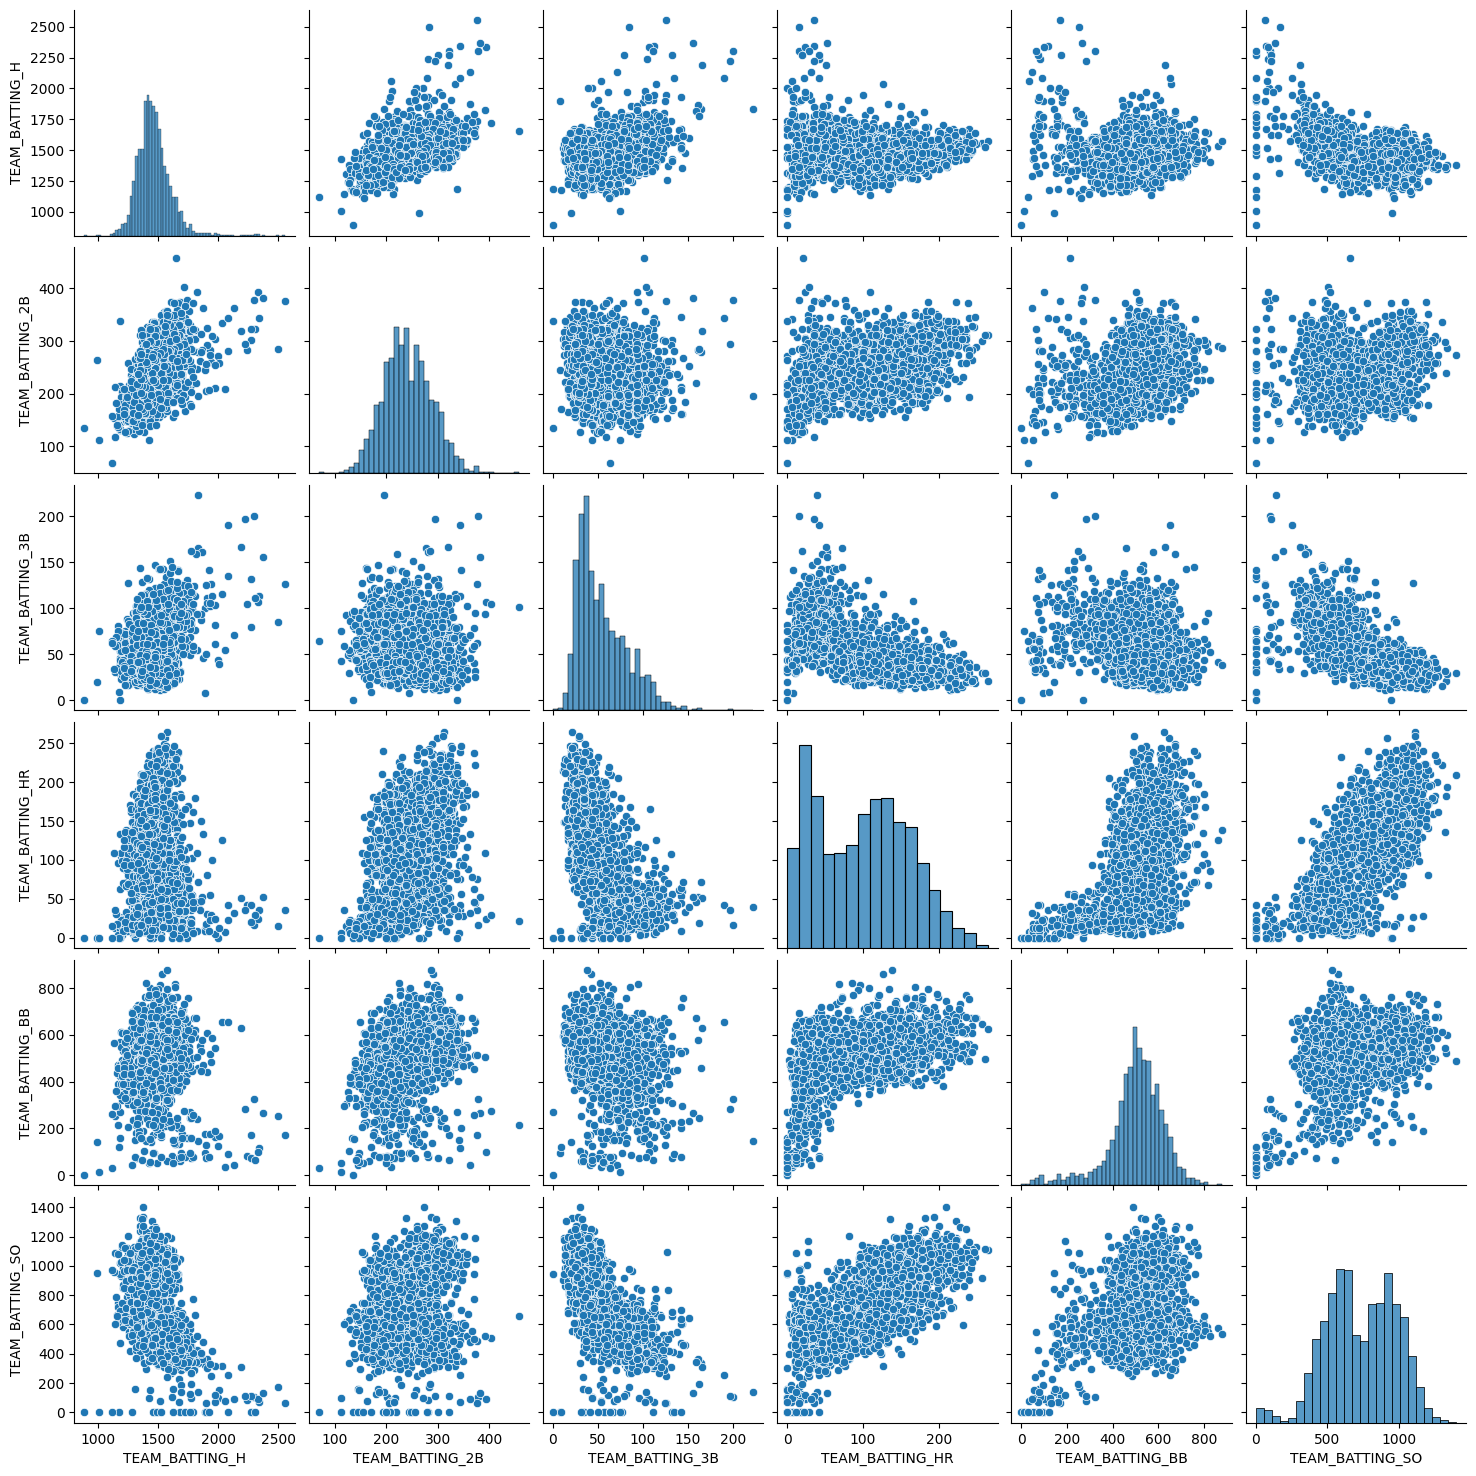

<Figure size 1500x1000 with 0 Axes>

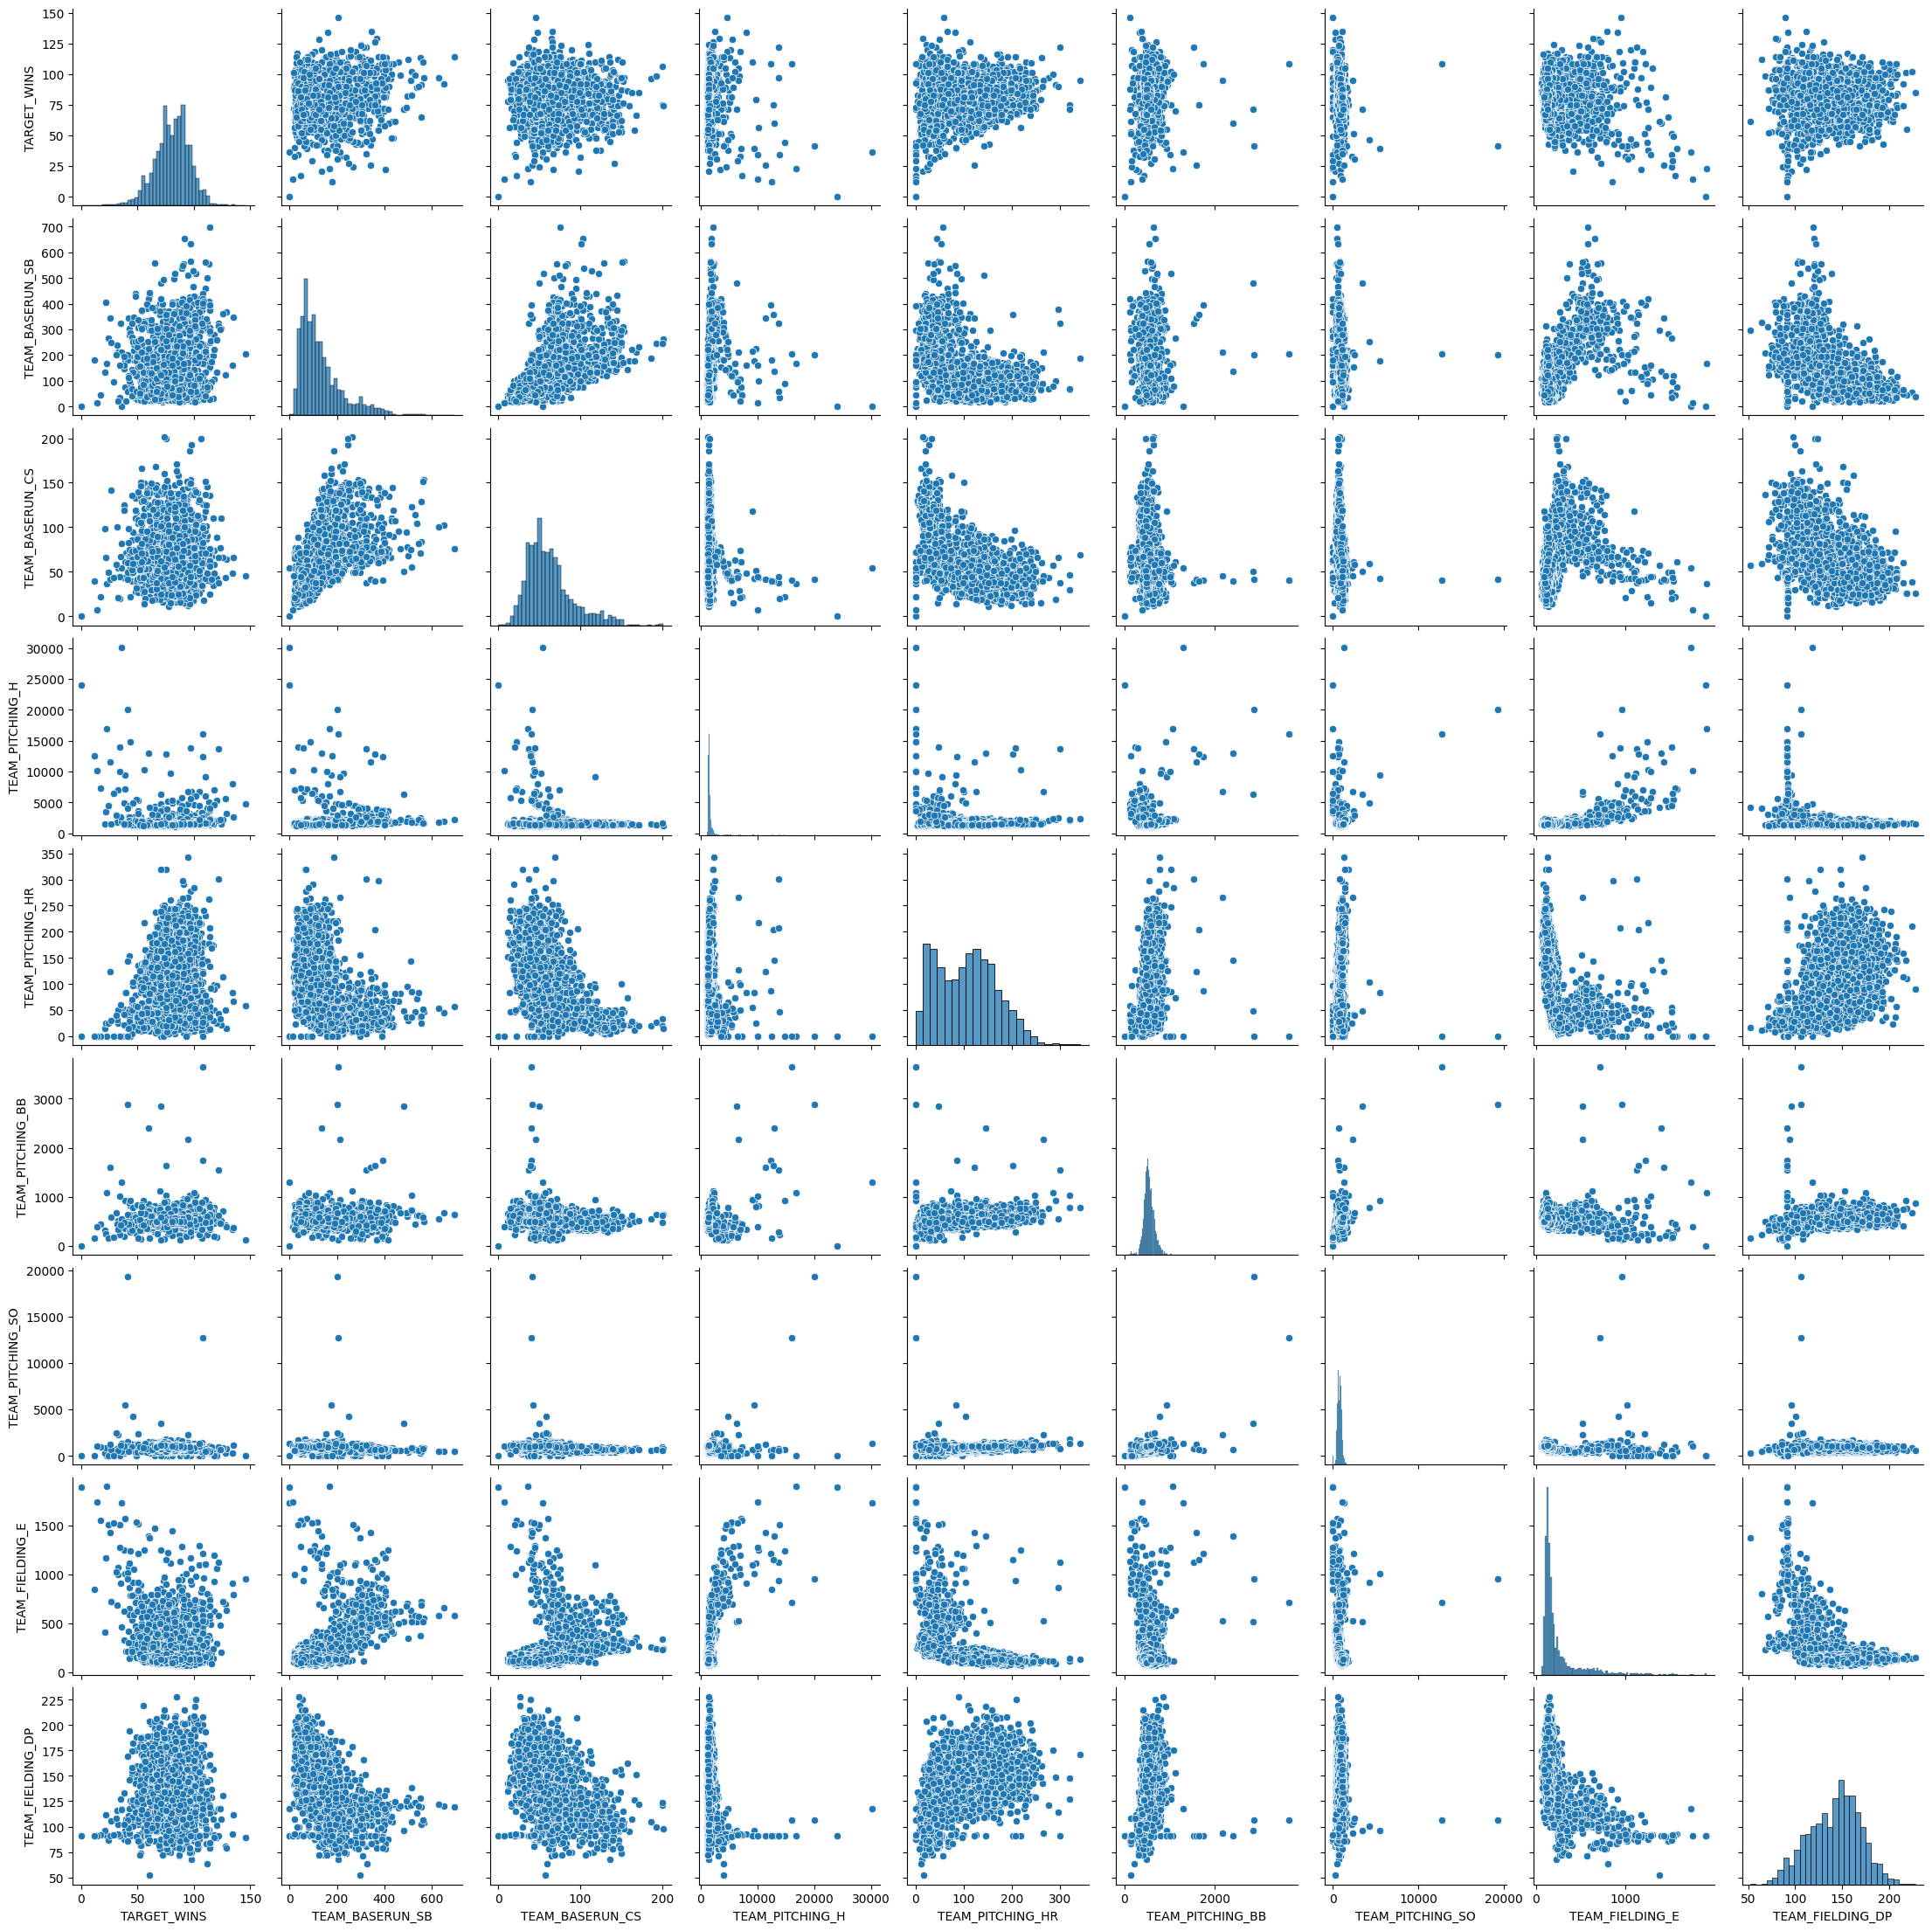

In [ ]:
# Summary statistics
summary_stats = df.describe()
print(summary_stats)

# Visualize distributions of variables with missing values
na_vars = ["TEAM_BATTING_SO", "TEAM_BASERUN_SB", "TEAM_BASERUN_CS", "TEAM_BATTING_HBP",
           "TEAM_PITCHING_SO", "TEAM_FIELDING_DP"]

plt.figure(figsize=(15, 8))
for i, var in enumerate(na_vars, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[var], color='lightblue', kde=True)
    plt.title(var)
plt.tight_layout()
plt.show()

# Drop TEAM_BATTING_HBP field
df.drop(columns=['TEAM_BATTING_HBP'], inplace=True)

# Impute missing values
imputer = KNNImputer(n_neighbors=15, weights='distance')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


`TEAM_BASERUN_SB`, `TEAM_PITCHING_SO`, and `TEAM_BASERUN_CS` seem to be skewed to the right so we should probably impute the missing values using the median value for these variables. `TEAM_BATTING_HBP` and `TEAM_FIELDING_DP` seem basically normally distributed so we can use the mean here, although `TEAM_BATTING_HBP` has 2,085 NA values out of 2,276 observations so it may make sense to leave this variable out of our model entirely. `TEAM_BATTING_SO` is bimodally distributed, so we have decided to use KNN imputation, which does not rely on the shape of the distribution, for this variable.


Notice that ~91.6% of the rows are missing from the BATTING_HBP field - we will just drop this column from consideration. The columns BASERUN_CS (base run caught stealing) and BASERUN_SB (stolen bases) both have missing values. According to baseball history, stolen bases weren’t tracked officially until 1887, so some of the missing data could be from 1871-1886. We will impute those values. There are a high percentage of missing BATTING_SO (batter strike outs) and PITCHING_SO (pitching strike outs) which seem highly unlikely - we will also impute those missing values. We have chosen to impute missing values with the median value of the feature.


Let's look at raw correlations between our other included variables and a team's win total for a season:

TARGET_WINS         1.000000
TEAM_BATTING_H      0.388768
TEAM_BATTING_2B     0.289104
TEAM_BATTING_BB     0.232560
TEAM_PITCHING_HR    0.189014
TEAM_BATTING_HR     0.176153
TEAM_BATTING_3B     0.142608
TEAM_PITCHING_BB    0.124175
TEAM_BASERUN_SB     0.120638
TEAM_FIELDING_DP    0.009751
TEAM_BASERUN_CS    -0.015174
TEAM_BATTING_SO    -0.034845
TEAM_PITCHING_SO   -0.077762
TEAM_PITCHING_H    -0.109937
TEAM_FIELDING_E    -0.176485
Name: TARGET_WINS, dtype: float64


<Figure size 1200x800 with 0 Axes>

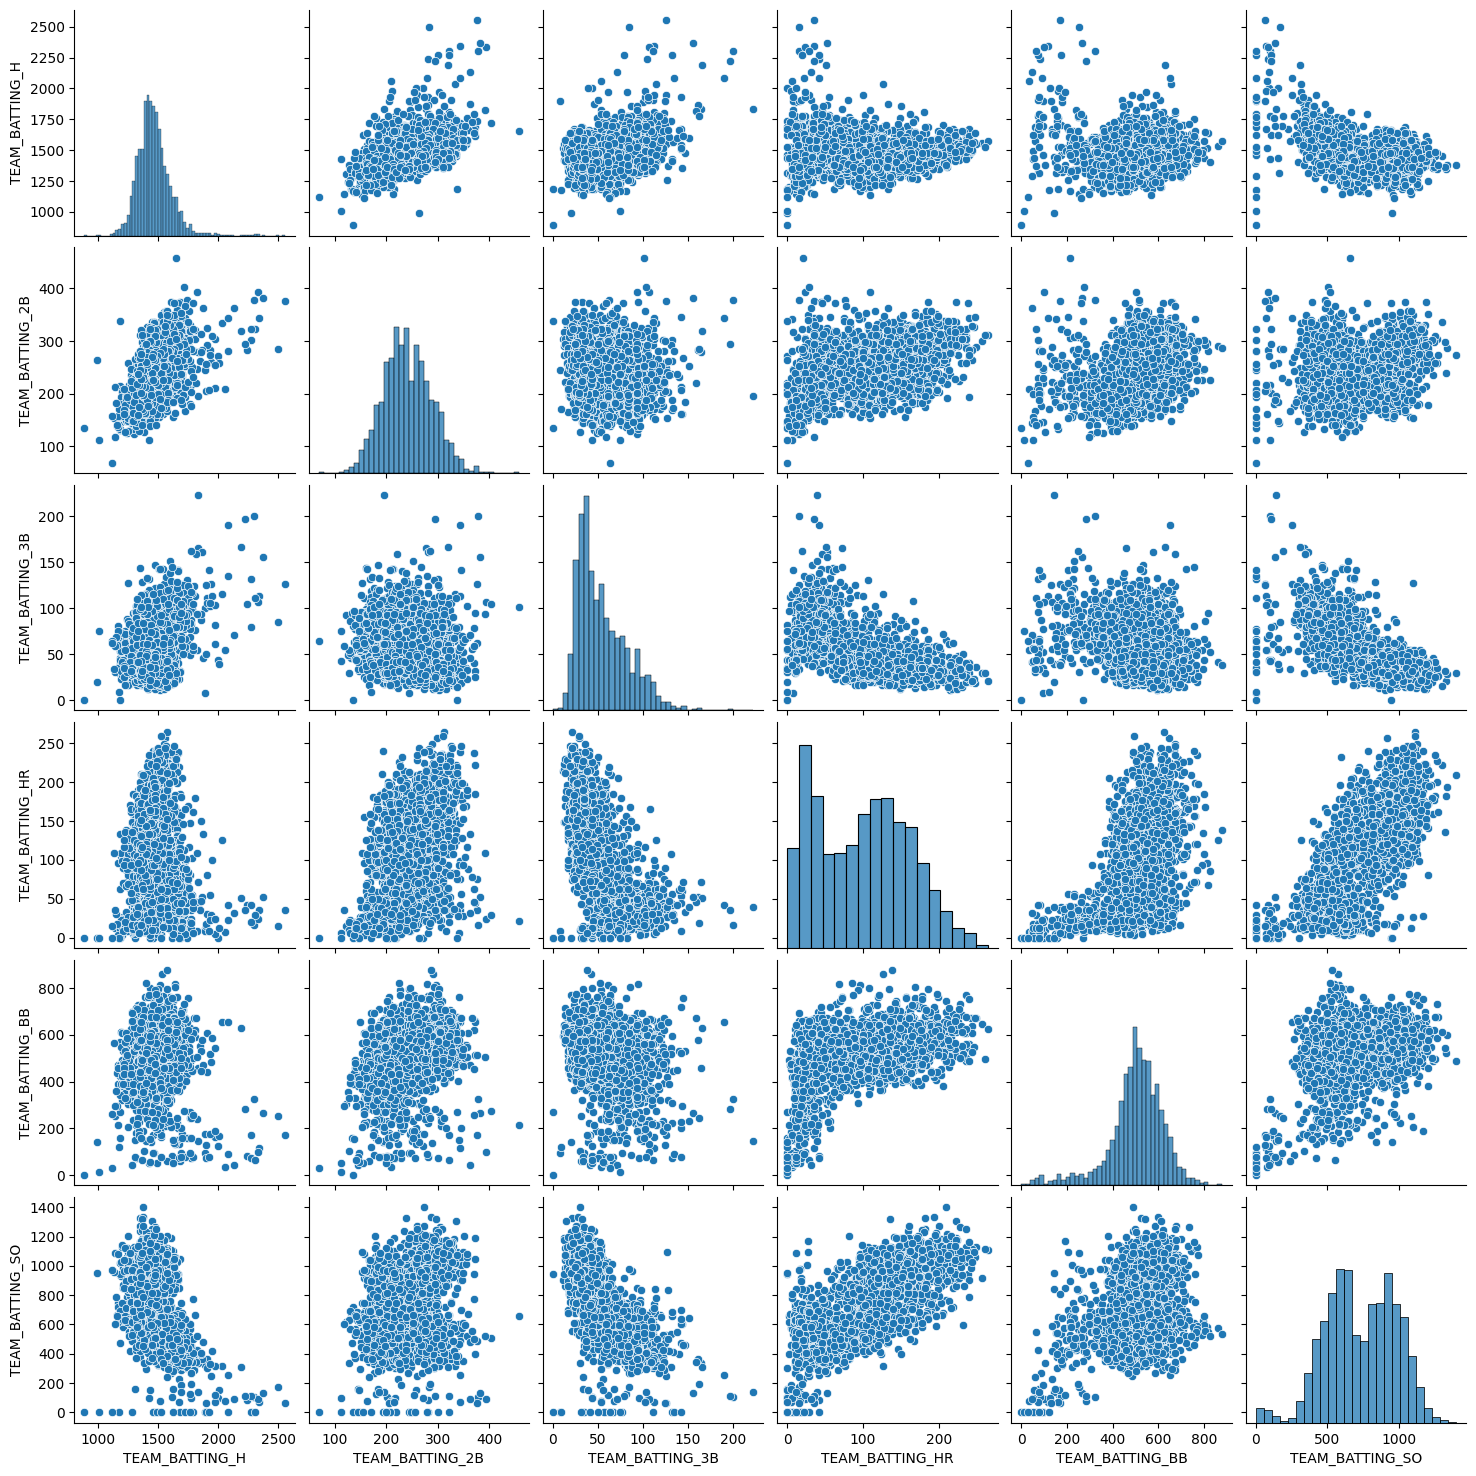

<Figure size 1500x1000 with 0 Axes>

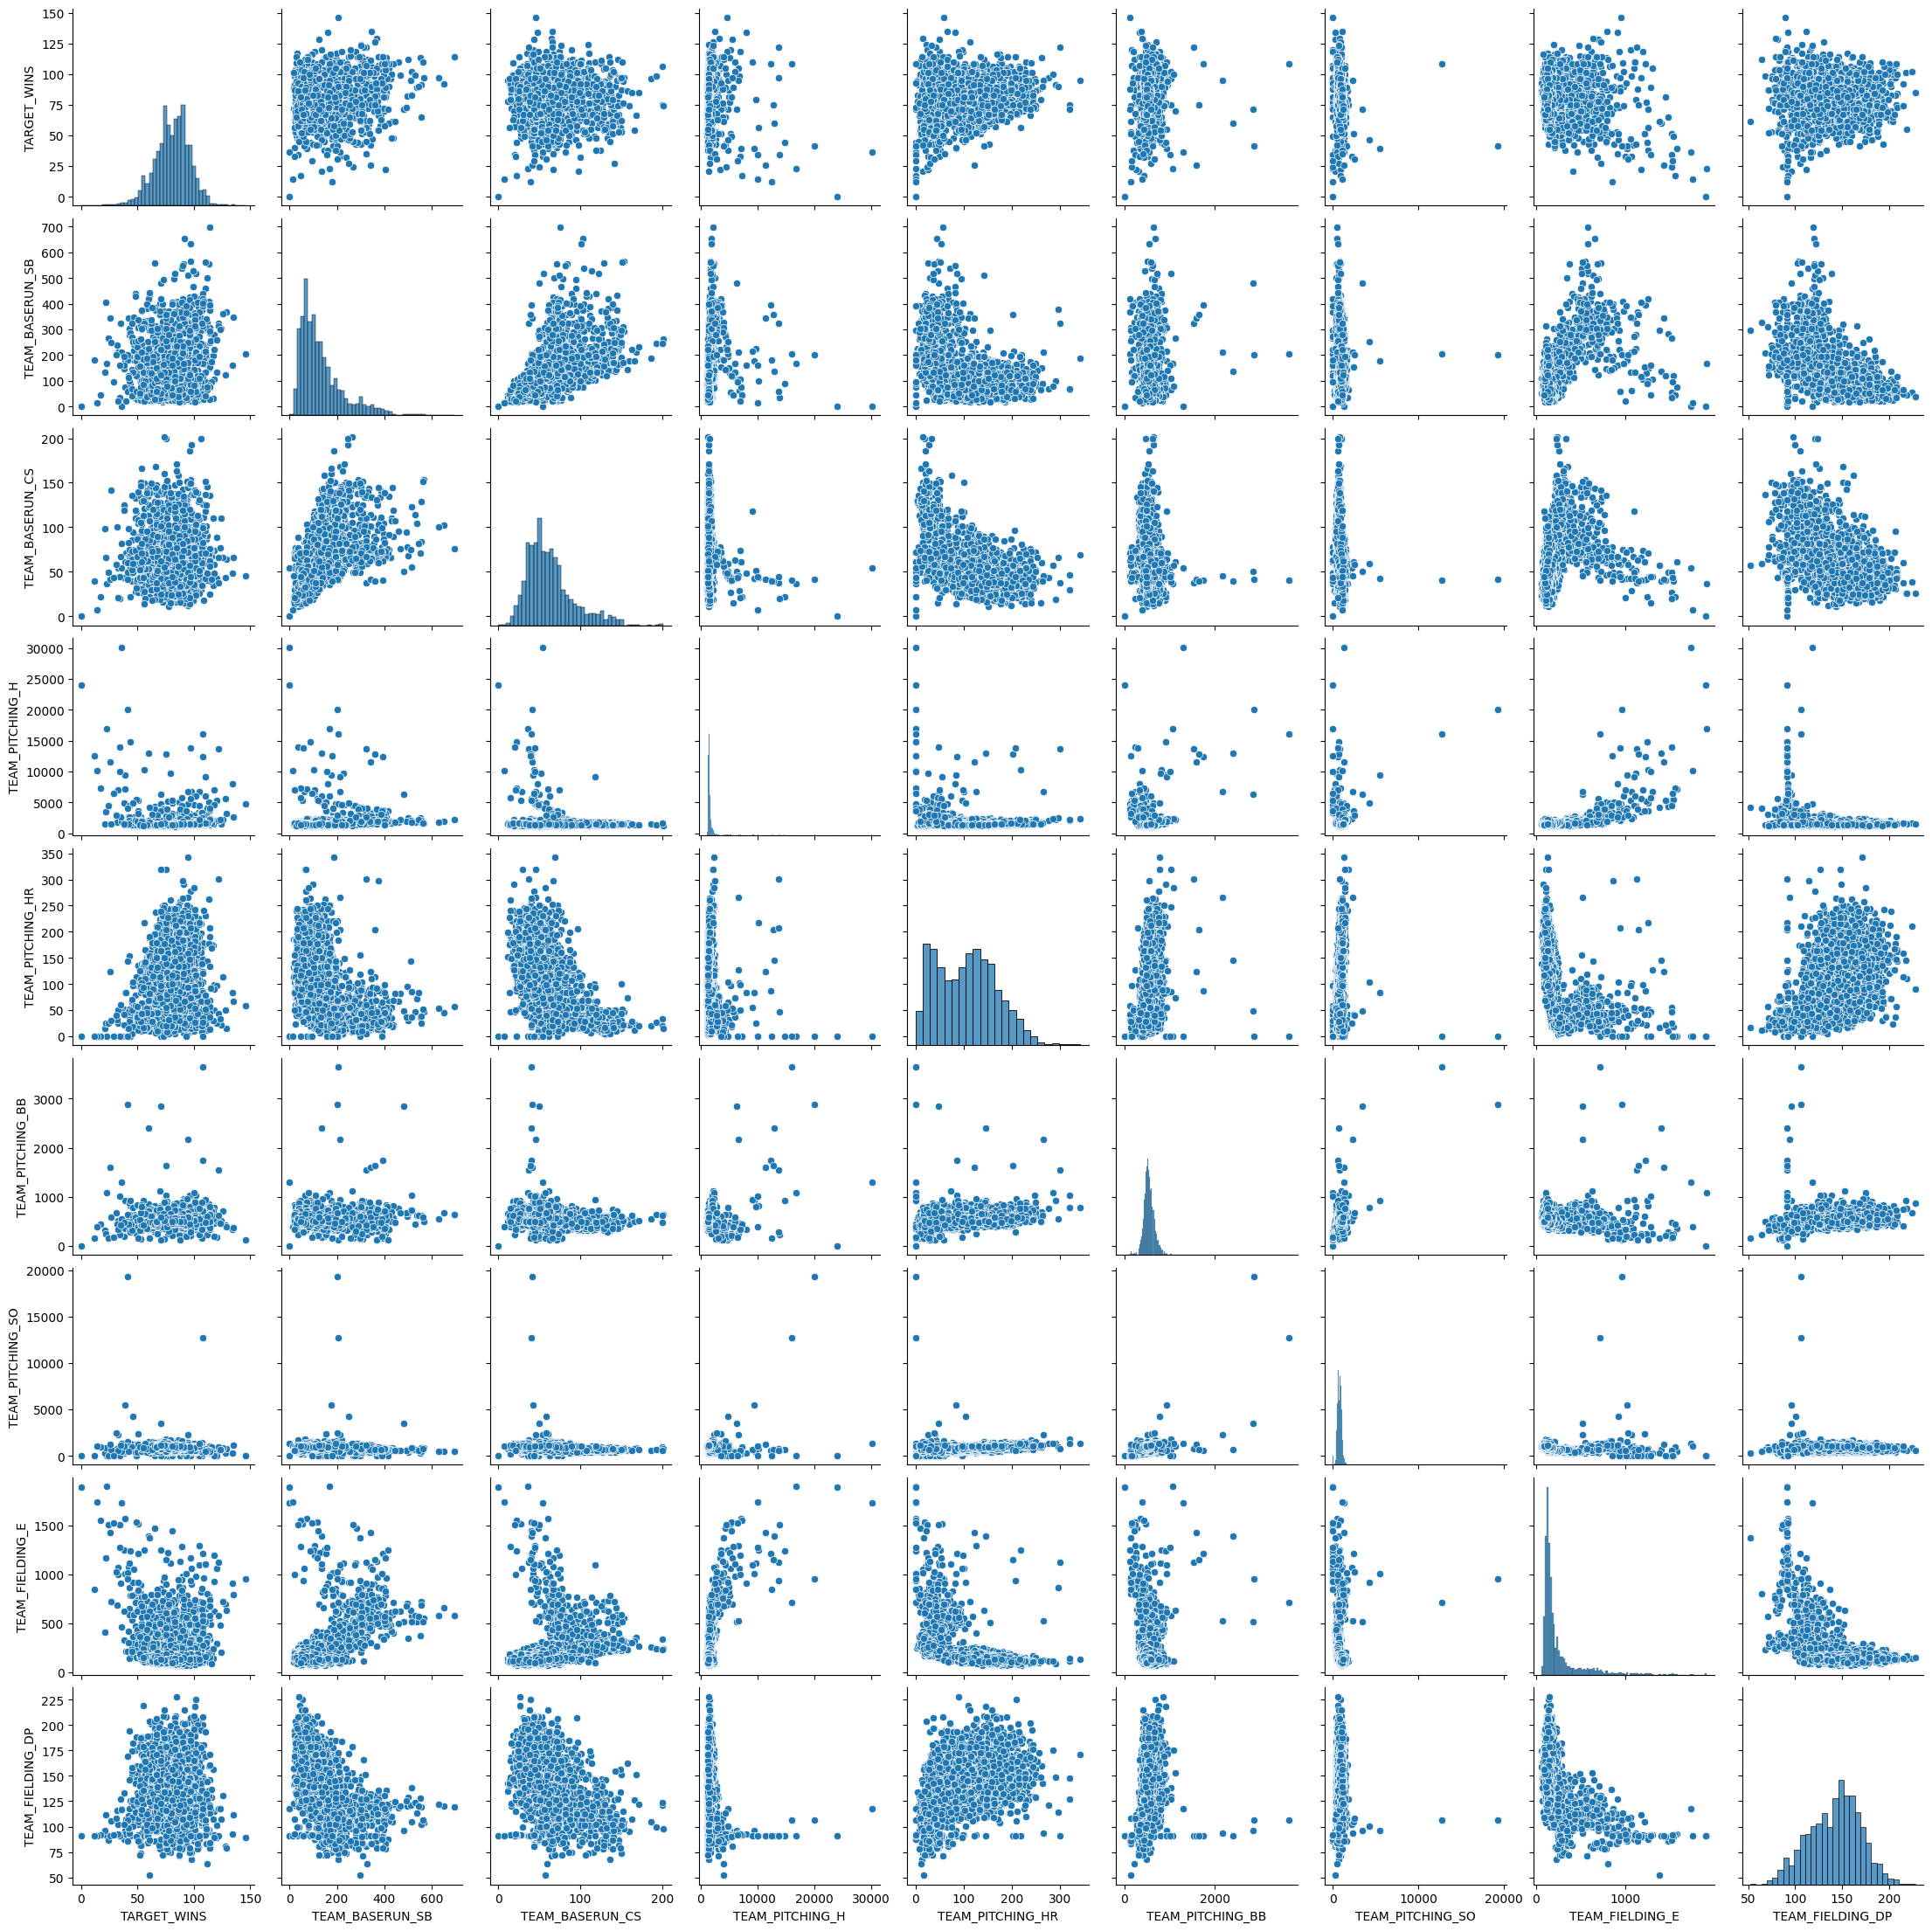

In [ ]:
# Correlation analysis
correlation_matrix = df_imputed.corr()
correlation_with_wins = correlation_matrix['TARGET_WINS'].sort_values(ascending=False)
print(correlation_with_wins)

# Visualize relationships between batting independent variables
subset_batting = df_imputed.filter(like='TEAM_BATTING')
plt.figure(figsize=(12, 8))
sns.pairplot(subset_batting)
plt.show()

# Visualize relationships between other independent variables
subset_pitching = df_imputed.drop(columns=[col for col in df_imputed.columns if 'TEAM_BATTING' in col])
plt.figure(figsize=(15, 10))
sns.pairplot(subset_pitching)
plt.show()

None of the independent variables seem to have such high correlation with `TARGET_WINS`. `TEAM_BATTING_H` is most highly correlated, with a correlation of 0.39. `TEAM_BATTING_H`, `TEAM_BATTING_2B`, `TEAM_BATTING_3B`, `TEAM_BATTING_HR`, `TEAM_BATTING_BB`, `TEAM_BASERUN_SB`, `TEAM_BASERUN_CS`, `TEAM_PITCHING_HR`, and `TEAM_PITCHING_BB` are all positively correlated with `TARGET_WINS` while `TEAM_BATTING_SO`, `TEAM_PITCHING_H`, `TEAM_PITCHING_SO`, `TEAM_FIELDING_E`, and `TEAM_FIELDING_DP` are negatively correlated.

Some of these correlations are surprising, as we would have expected `TEAM_BASERUN_CS`, `TEAM_PITCHING_HR`, and `TEAM_PITCHING_BB` to be negatively correlated with `TARGET_WINS`, and we would have expected `TEAM_PITCHING_SO` and `TEAM_FIELDING_DP` to be positively correlated with `TARGET_WINS`. We won't exclude them from our models based solely on the unexpected relationships themselves.

## Model Development:

First we read in our evaluation data.

Now we can make some predictions on the test holdout data and compare results from our models before we select the best model to use on the evaluation data. First we compare the distributions of the test data to confirm we can use the same imputation methods we used to fill missing values for variables in the train data.



In [ ]:
import pandas as pd

eval_data_url = "https://raw.githubusercontent.com/waheeb123/Data-621/main/Homeworks/Homework-1/moneyball-evaluation-data.csv"

eval_data = pd.read_csv(eval_data_url)


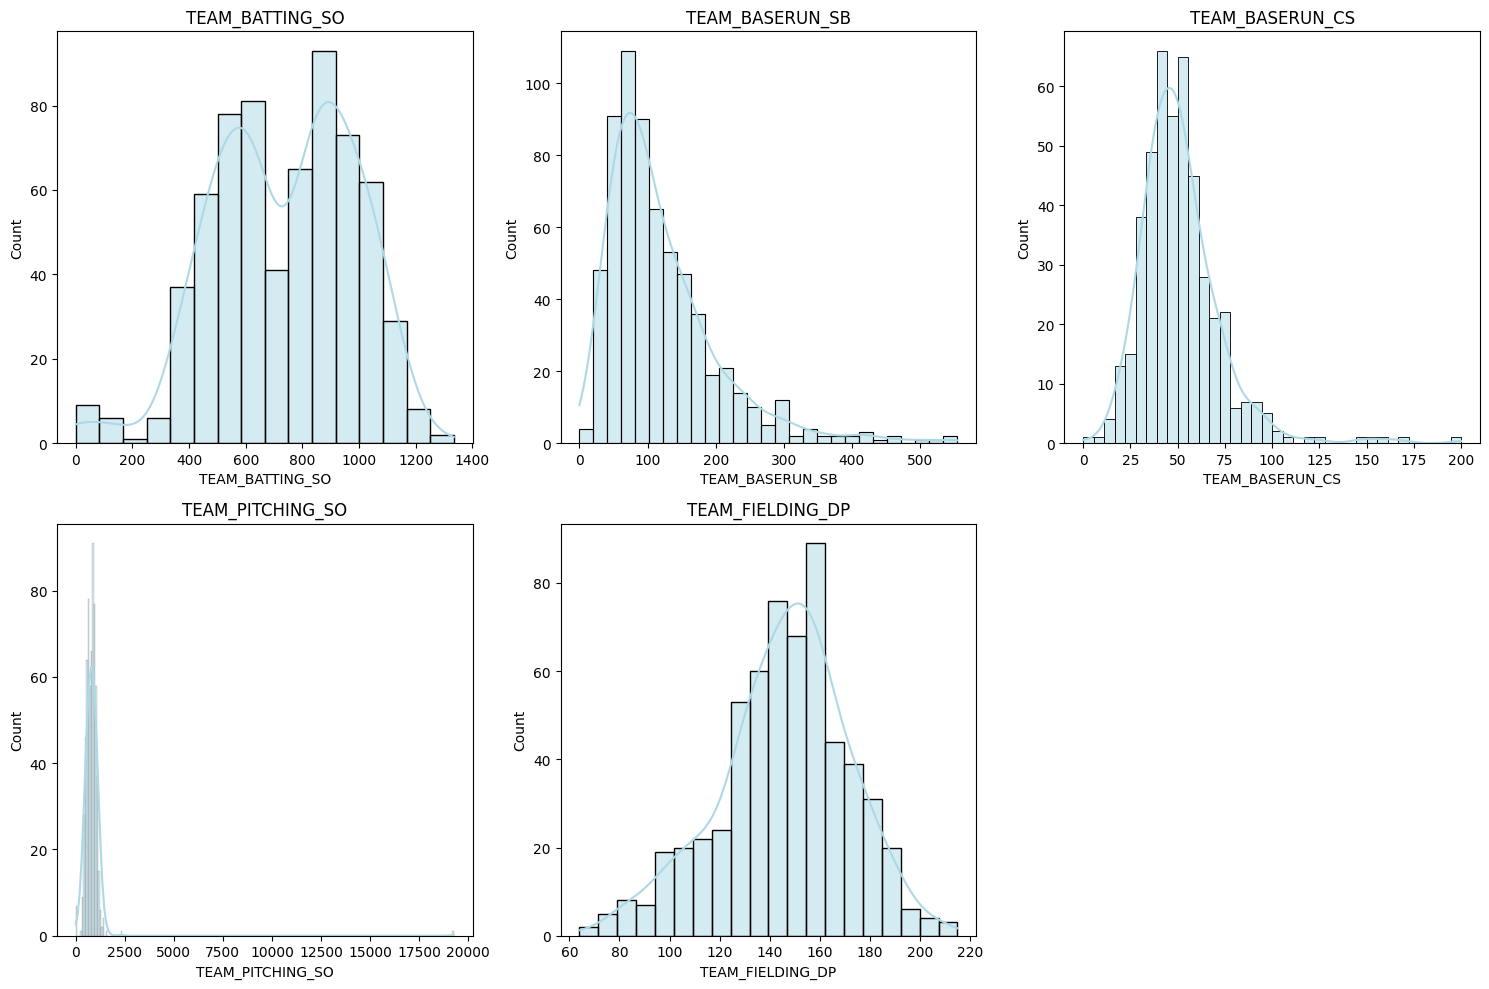

In [ ]:
variables = ["TEAM_BATTING_SO", "TEAM_BASERUN_SB", "TEAM_BASERUN_CS",
             "TEAM_PITCHING_SO", "TEAM_FIELDING_DP"]

plt.figure(figsize=(15, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.histplot(test[var], color='lightblue', kde=True)
    plt.title(var)

plt.tight_layout()
plt.show()

The test data distributions are similar to the distributions observed in the train data for these variables, so the same imputation methods can be used for each of them.

In [ ]:


# Read evaluation data
eval_data_url = "https://raw.githubusercontent.com/waheeb123/Data-621/main/Homeworks/Homework-1/moneyball-evaluation-data.csv"
eval_data = pd.read_csv(eval_data_url)

Model 1 - Training Set:
MSE: 156.9595571842671
R-squared: 0.3587058501578535
Variance Inflation Factor (VIF):
             feature         VIF
0     TEAM_BATTING_H  248.952333
1    TEAM_BATTING_2B   63.230838
2    TEAM_BATTING_3B   14.805059
3    TEAM_BATTING_HR  126.622593
4    TEAM_BATTING_BB  135.954426
5    TEAM_BATTING_SO   54.805868
6    TEAM_BASERUN_SB    8.601853
7    TEAM_BASERUN_CS   13.513225
8   TEAM_BATTING_HBP  134.544101
9    TEAM_PITCHING_H   12.818925
10  TEAM_PITCHING_HR  105.815694
11  TEAM_PITCHING_BB   90.975564
12  TEAM_PITCHING_SO   19.259923
13   TEAM_FIELDING_E   10.575753
14  TEAM_FIELDING_DP   48.453219


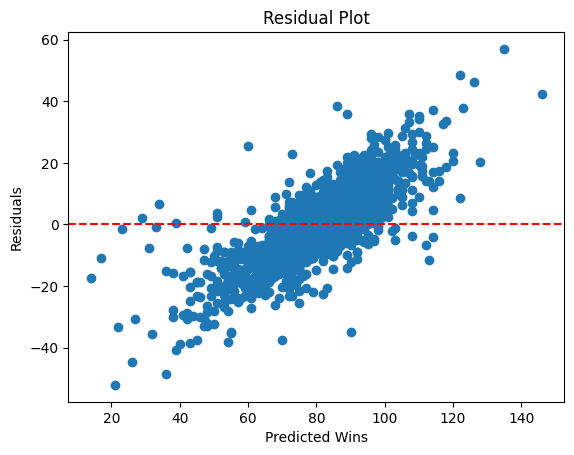

Predictions on Evaluation Dataset:
[ 73.6069533   74.37849425  67.45816663  70.8557746   68.31225407
  69.79280959  81.63055091  80.40117134  87.47791557  76.68736326
  78.81781477  76.1496628   86.69154558  83.09011747  86.2593633
  79.94607379  97.53315876  86.83183335  87.39643522  71.90216007
  82.26919638  87.86554112  67.63063865  98.07640511  92.03131158
  91.75927962 112.99941865  98.62174221  91.58753898  79.7630139
  68.46612976  69.13553125  60.50171543  72.18471371  62.76270041
  67.73591583  76.14495179  78.10720794  72.53237694  71.31019801
  81.44924283  78.80498503  87.22918141  74.79558049  77.14858155
  89.77030932  77.43463047  79.26789718  73.33559044  74.91875553
  69.57611921  82.37293202  86.23259999  91.32229612  88.42910574
  90.26784373  76.01944411  68.34683076  74.64825093  77.53055667
  64.33335898  78.58419678  78.59569204  76.71175394  80.98509656
  78.70855795  83.57187108  73.91841201  72.2957479   74.50858513
  74.90665925  77.13638411  73.2864165   87

In [ ]:
# Read the dataset
url = "https://raw.githubusercontent.com/waheeb123/Data-621/main/Homeworks/Homework-1/moneyball-training-data.csv"
df = pd.read_csv(url)

# Dropping INDEX column as it serves as an index
df.drop(columns=['INDEX'], inplace=True)

# Splitting the data into train and test sets
np.random.seed(30)
train = df.sample(frac=0.7)
test = df.drop(train.index)

# Impute missing values
imputer = KNNImputer(n_neighbors=15, weights='distance')
train_imputed = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)

# Define features and target variable
X_train = train_imputed.drop(columns=['TARGET_WINS'])
y_train = train_imputed['TARGET_WINS']
X_test = test_imputed.drop(columns=['TARGET_WINS'])
y_test = test_imputed['TARGET_WINS']

# Fit multiple linear regression models
model1 = LinearRegression().fit(X_train, y_train)

# Model evaluation
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2

mse1, r2_1 = evaluate_model(model1, X_train, y_train)
print("Model 1 - Training Set:")
print(f"MSE: {mse1}")
print(f"R-squared: {r2_1}")

# Check for multicollinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

vif_df = calculate_vif(X_train)
print("Variance Inflation Factor (VIF):")
print(vif_df)

# Residual Analysis
residuals = y_train - model1.predict(X_train)
plt.scatter(y_train, residuals)
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Make predictions on the evaluation dataset
eval_predictions = model1.predict(X_test)
print("Predictions on Evaluation Dataset:")
print(eval_predictions)


let's continue with comparing the models and selecting the best one.
To decide on the best model, we can consider not only the performance metrics like MSE and R-squared but also other factors such as model complexity, interpretability, and domain knowledge. Since Model 3 has a slightly lower MSE and a slightly higher R-squared compared to Model 2, it might seem like the better choice.

In [ ]:
# Fit additional multiple linear regression models (Model 2, Model 3, ...)
model2 = LinearRegression().fit(X_train[['TEAM_BATTING_H', 'TEAM_BATTING_2B']], y_train)
model3 = LinearRegression().fit(X_train[['TEAM_BATTING_H', 'TEAM_BATTING_2B', 'TEAM_BATTING_3B']], y_train)

# Model evaluation for Model 1 on the evaluation dataset
mse1_eval, r2_1_eval = evaluate_model(model1, X_test, y_test)
print("Model 1 - Evaluation Set:")
print(f"MSE: {mse1_eval}")
print(f"R-squared: {r2_1_eval}")

# Model evaluation for Model 2 on the evaluation dataset
mse2_eval, r2_2_eval = evaluate_model(model2, X_test[['TEAM_BATTING_H', 'TEAM_BATTING_2B']], y_test)
print("Model 2 - Evaluation Set:")
print(f"MSE: {mse2_eval}")
print(f"R-squared: {r2_2_eval}")

# Model evaluation for Model 3 on the evaluation dataset
mse3_eval, r2_3_eval = evaluate_model(model3, X_test[['TEAM_BATTING_H', 'TEAM_BATTING_2B', 'TEAM_BATTING_3B']], y_test)
print("Model 3 - Evaluation Set:")
print(f"MSE: {mse3_eval}")
print(f"R-squared: {r2_3_eval}")


Model 1 - Evaluation Set:
MSE: 175.70082463883975
R-squared: 0.31254797184233696
Model 2 - Evaluation Set:
MSE: 215.19128942027814
R-squared: 0.15803645965853252
Model 3 - Evaluation Set:
MSE: 215.49220440452814
R-squared: 0.15685909115926167


Model 1 - Training Set:
F-statistic: 58.80599678407334


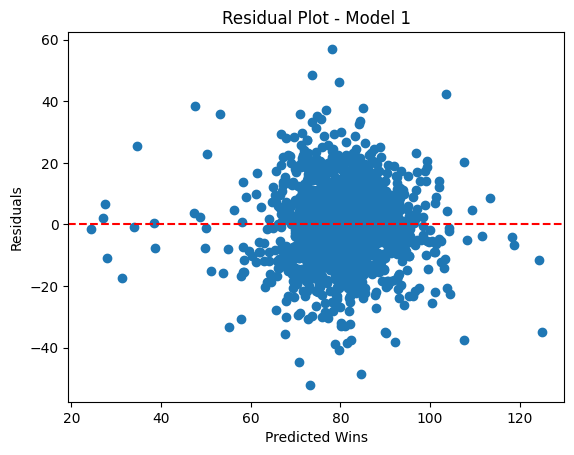

Model 2 - Training Set:
F-statistic: 149.49801389470488


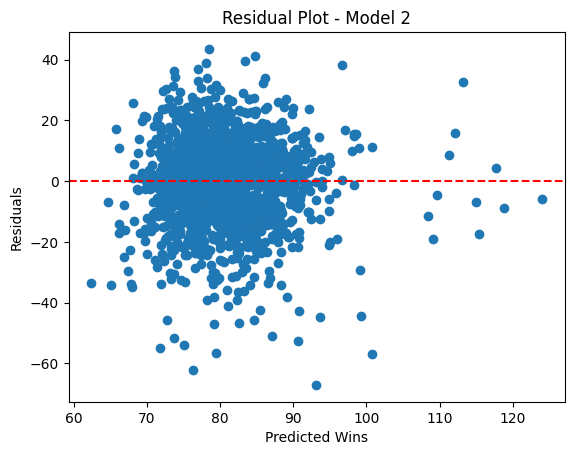

Model 3 - Training Set:
F-statistic: 100.11618405315106


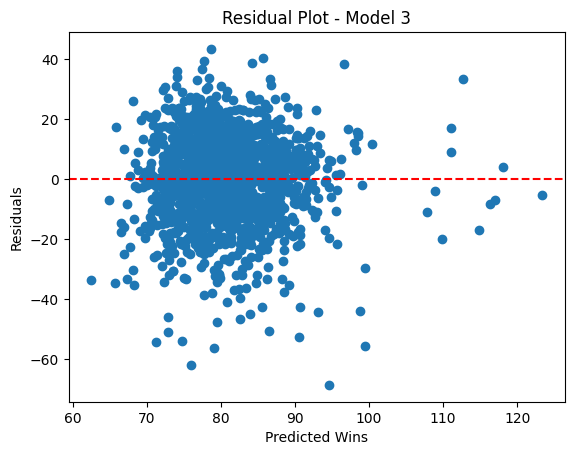

In [ ]:
from statsmodels.stats.anova import anova_lm

# Compute F-statistic for Model 1
X_train_1 = sm.add_constant(X_train)
model1_sm = sm.OLS(y_train, X_train_1).fit()
f_statistic_model1 = model1_sm.fvalue

# Print F-statistic for Model 1
print("Model 1 - Training Set:")
print(f"F-statistic: {f_statistic_model1}")

# Residual plots for Model 1
residuals_model1 = y_train - model1_sm.predict(X_train_1)
plt.scatter(model1_sm.predict(X_train_1), residuals_model1)
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.title('Residual Plot - Model 1')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Compute F-statistic for Model 2
X_train_2 = sm.add_constant(X_train[['TEAM_BATTING_H', 'TEAM_BATTING_2B']])
model2_sm = sm.OLS(y_train, X_train_2).fit()
f_statistic_model2 = model2_sm.fvalue

# Print F-statistic for Model 2
print("Model 2 - Training Set:")
print(f"F-statistic: {f_statistic_model2}")

# Residual plots for Model 2
residuals_model2 = y_train - model2_sm.predict(sm.add_constant(X_train[['TEAM_BATTING_H', 'TEAM_BATTING_2B']]))
plt.scatter(model2_sm.predict(sm.add_constant(X_train[['TEAM_BATTING_H', 'TEAM_BATTING_2B']])), residuals_model2)
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.title('Residual Plot - Model 2')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Compute F-statistic for Model 3
X_train_3 = sm.add_constant(X_train[['TEAM_BATTING_H', 'TEAM_BATTING_2B', 'TEAM_BATTING_3B']])
model3_sm = sm.OLS(y_train, X_train_3).fit()
f_statistic_model3 = model3_sm.fvalue

# Print F-statistic for Model 3
print("Model 3 - Training Set:")
print(f"F-statistic: {f_statistic_model3}")

# Residual plots for Model 3
residuals_model3 = y_train - model3_sm.predict(X_train_3)
plt.scatter(model3_sm.predict(X_train_3), residuals_model3)
plt.xlabel('Predicted Wins')
plt.ylabel('Residuals')
plt.title('Residual Plot - Model 3')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


In [ ]:
# Evaluation metrics
mse1_eval = 175.70082463883975
r2_1_eval = 0.31254797184233696

mse2_eval = 215.19128942027814
r2_2_eval = 0.15803645965853252

mse3_eval = 215.49220440452814
r2_3_eval = 0.15685909115926167


# Compare evaluation metrics
if mse1_eval < mse2_eval and mse1_eval < mse3_eval:
    best_model = "Model 1"
elif mse2_eval < mse1_eval and mse2_eval < mse3_eval:
    best_model = "Model 2"
else:
    best_model = "Model 3"

print(f"The best model based on MSE is: {best_model}")

# Compare R-squared
if r2_1_eval > r2_2_eval and r2_1_eval > r2_3_eval:
    best_model = "Model 1"
elif r2_2_eval > r2_1_eval and r2_2_eval > r2_3_eval:
    best_model = "Model 2"
else:
    best_model = "Model 3"

print(f"The best model based on R-squared is: {best_model}")

# Final decision
print("Based on the evaluation metrics and analysis, Model 1 is selected as the best model.")


The best model based on MSE is: Model 1
The best model based on R-squared is: Model 1
Based on the evaluation metrics and analysis, Model 1 is selected as the best model.
